# Dataset Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Loading and merging train/test .txt files
df_train = pd.read_csv("Train.txt", header=None)
df_test = pd.read_csv("Test.txt", header=None)
df = pd.concat([df_train, df_test], ignore_index=True)

# Assigning column names manually (last column is 'attack')
df.columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "attack", "last_flag"
]

# Mapping detailed attacks to high-level categories
attack_mapping = {
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L',
    'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
    'normal': 'Normal'
}

# Applying mapping
df['attack_class'] = df['attack'].map(attack_mapping)
df = df[df['attack_class'].notnull()]  # Drop unknown attacks

# Create binary anomaly label
df['is_anomaly'] = df['attack_class'].apply(lambda x: 0 if x == 'Normal' else 1)

# Encoding categorical columns
df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])

# Encoding multi-class target
attack_encoder = LabelEncoder()
df['attack_class_encoded'] = attack_encoder.fit_transform(df['attack_class'])

# Preparing features and labels
features = df.drop(columns=['attack', 'attack_class', 'attack_class_encoded', 'is_anomaly', 'last_flag'])
X = StandardScaler().fit_transform(features.values)
y_anomaly = df['is_anomaly'].values
y_attack = df['attack_class_encoded'].values

# Converting to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_anomaly_tensor = torch.tensor(y_anomaly, dtype=torch.float32)
y_attack_tensor = torch.tensor(y_attack, dtype=torch.long)


X_train, X_test, y_anom_train, y_anom_test, y_att_train, y_att_test = train_test_split(
    X_tensor, y_anomaly_tensor, y_attack_tensor, test_size=0.2, stratify=y_attack_tensor, random_state=42
)


train_dataset = TensorDataset(X_train, y_anom_train, y_att_train)
test_dataset = TensorDataset(X_test, y_anom_test, y_att_test)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)




<ipython-input-17-c2c45d04c5db>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_anomaly'] = df['attack_class'].apply(lambda x: 0 if x == 'Normal' else 1)


In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 144767 entries, 0 to 148515
Columns: 127 entries, duration to attack_class_encoded
dtypes: bool(84), float64(15), int64(26), object(2)
memory usage: 60.2+ MB
None


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144767 entries, 0 to 148515
Columns: 122 entries, duration to flag_SH
dtypes: bool(84), float64(15), int64(23)
memory usage: 54.7 MB


In [ ]:
final_feature_names = features.columns.tolist()

print("Final Feature Names:")
print(final_feature_names)


Final Feature Names:
['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u'

In [ ]:
# Computing and display attack class distribution in train and test data
train_labels, train_counts = np.unique(y_att_train.numpy(), return_counts=True)
test_labels, test_counts = np.unique(y_att_test.numpy(), return_counts=True)

train_distribution = {attack_encoder.classes_[i]: train_counts[i] for i in range(len(train_labels))}
test_distribution = {attack_encoder.classes_[i]: test_counts[i] for i in range(len(test_labels))}

print("Train Data Attack Class Distribution:")
print(train_distribution)
print("\nTest Data Attack Class Distribution:")
print(test_distribution)


Train Data Attack Class Distribution:
{'DoS': np.int64(41334), 'Normal': np.int64(61643), 'Probe': np.int64(10210), 'R2L': np.int64(2555), 'U2R': np.int64(71)}

Test Data Attack Class Distribution:
{'DoS': np.int64(10334), 'Normal': np.int64(15411), 'Probe': np.int64(2552), 'R2L': np.int64(639), 'U2R': np.int64(18)}


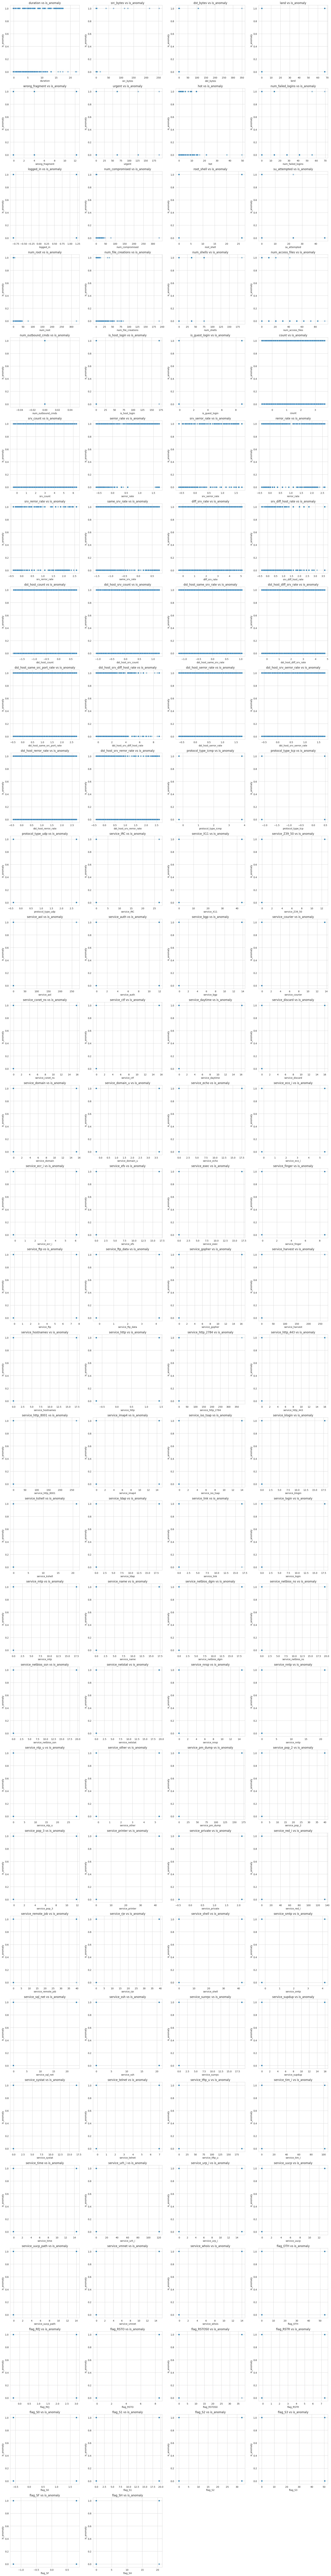

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Converting back to DataFrame for plotting
X_df = pd.DataFrame(X, columns=features.columns)
X_df['is_anomaly'] = y_anomaly  # Target column

sns.set_style("whitegrid")

# Selecting numerical features
num_features = X_df.select_dtypes(include=[np.number]).columns.tolist()
num_features.remove("is_anomaly")  # Exclude target column

# Calculating grid size
num_plots = len(num_features)
cols = 4
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.scatterplot(data=X_df, x=col, y="is_anomaly", ax=axes[i], alpha=0.5)
    axes[i].set_title(f"{col} vs is_anomaly")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Feature Ranges and Null Counts:
                             min           max  null_count
duration                     0.0  5.445100e+04           0
src_bytes                    0.0  1.379964e+09           0
dst_bytes                    0.0  1.309937e+09           0
land                         0.0  1.000000e+00           0
wrong_fragment               0.0  3.000000e+00           0
urgent                       0.0  3.000000e+00           0
hot                          0.0  1.010000e+02           0
num_failed_logins            0.0  5.000000e+00           0
logged_in                    0.0  1.000000e+00           0
num_compromised              0.0  7.479000e+03           0
root_shell                   0.0  1.000000e+00           0
su_attempted                 0.0  2.000000e+00           0
num_root                     0.0  7.468000e+03           0
num_file_creations           0.0  1.000000e+02           0
num_shells                   0.0  5.000000e+00           0
num_access_files        

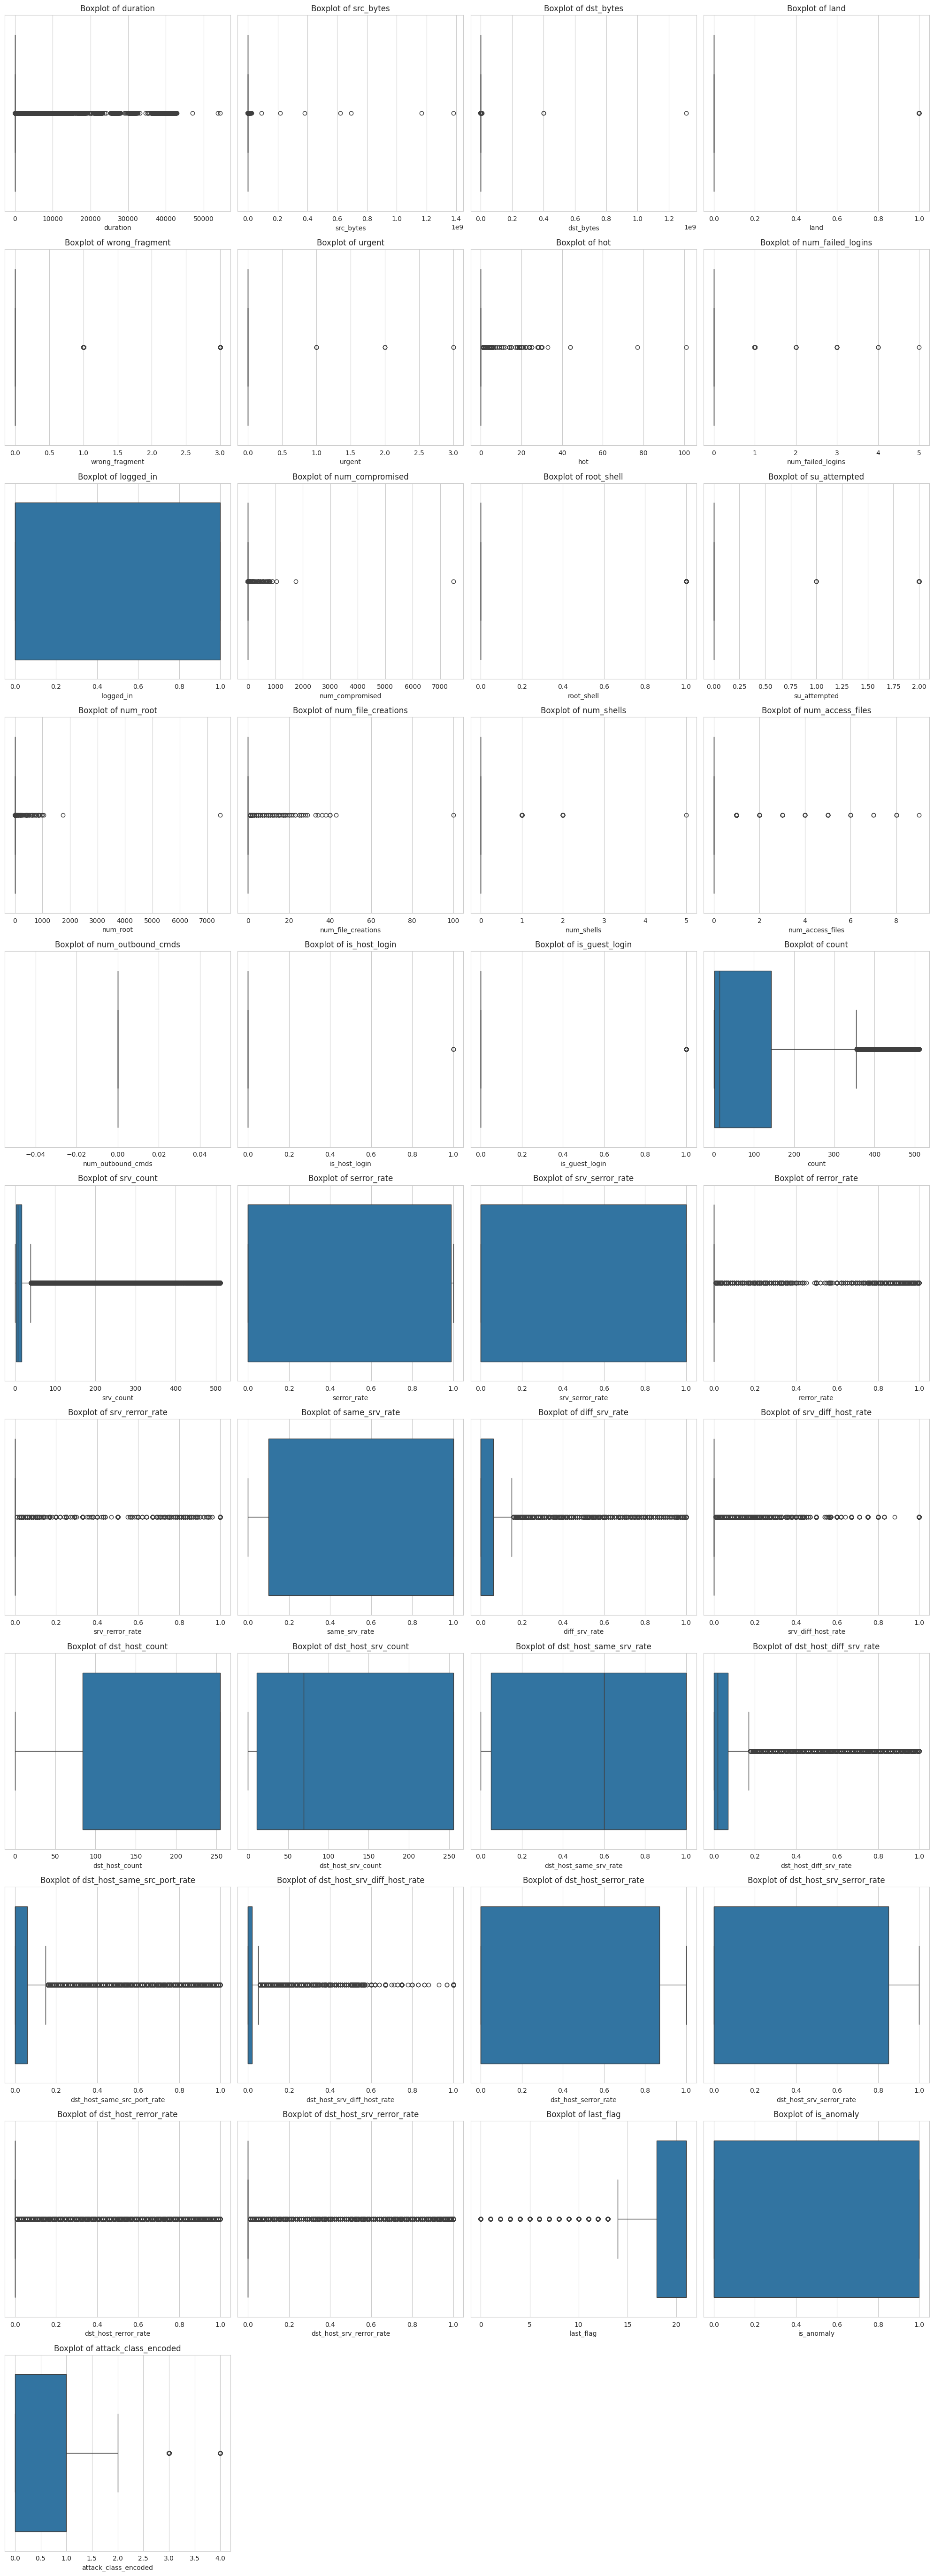

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Getting Range of Values and Null Counts
feature_ranges = df.describe().T[['min', 'max']]
null_counts = df.isnull().sum()
summary_df = feature_ranges.copy()
summary_df['null_count'] = null_counts

print("Feature Ranges and Null Counts:")
print(summary_df)

# Box Plot Distribution for Each Feature
num_features = df.select_dtypes(include=[np.number]).columns.tolist()

sns.set_style("whitegrid")

num_plots = len(num_features)
cols = 4
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Converting back to DataFrame for correlation analysis
X_df = pd.DataFrame(X, columns=features.columns)
X_df['is_anomaly'] = y_anomaly  # Add target column

# Computing correlation with is_anomaly
correlation_matrix = X_df.corr()
correlation_with_anomaly = correlation_matrix["is_anomaly"].abs().sort_values(ascending=False)

# Displaying the top correlated features (excluding is_anomaly itself)
top_correlated_features = correlation_with_anomaly.drop("is_anomaly").head(10)
print(top_correlated_features)


flag_SF                     0.739001
same_srv_rate               0.735393
dst_host_srv_count          0.714235
dst_host_same_srv_rate      0.686072
logged_in                   0.672942
dst_host_srv_serror_rate    0.612150
dst_host_serror_rate        0.609529
serror_rate                 0.608043
flag_S0                     0.607331
srv_serror_rate             0.605777
Name: is_anomaly, dtype: float64


# Basic AutoEncoder Model

In [ ]:

# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Training autoencoder
autoencoder = Autoencoder(X.shape[1])
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion_ae = nn.MSELoss()

for epoch in range(30):
    total_loss = 0
    for batch in train_loader:
        inputs, _, _ = batch
        optimizer_ae.zero_grad()
        outputs, _ = autoencoder(inputs)
        loss = criterion_ae(outputs, inputs)
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item()
    print(f"Autoencoder Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")




Autoencoder Epoch 1, Loss: 1.0220
Autoencoder Epoch 2, Loss: 0.9993
Autoencoder Epoch 3, Loss: 0.9994
Autoencoder Epoch 4, Loss: 0.9984
Autoencoder Epoch 5, Loss: 0.9981
Autoencoder Epoch 6, Loss: 0.9996
Autoencoder Epoch 7, Loss: 0.9987
Autoencoder Epoch 8, Loss: 0.9873
Autoencoder Epoch 9, Loss: 0.9650
Autoencoder Epoch 10, Loss: 0.9645
Autoencoder Epoch 11, Loss: 0.9633
Autoencoder Epoch 12, Loss: 0.9630
Autoencoder Epoch 13, Loss: 0.9624
Autoencoder Epoch 14, Loss: 0.9623
Autoencoder Epoch 15, Loss: 0.9593
Autoencoder Epoch 16, Loss: 0.9554
Autoencoder Epoch 17, Loss: 0.9534
Autoencoder Epoch 18, Loss: 0.9550
Autoencoder Epoch 19, Loss: 0.9550
Autoencoder Epoch 20, Loss: 0.9526
Autoencoder Epoch 21, Loss: 0.9608
Autoencoder Epoch 22, Loss: 0.9511
Autoencoder Epoch 23, Loss: 0.9518
Autoencoder Epoch 24, Loss: 0.9518
Autoencoder Epoch 25, Loss: 0.9515
Autoencoder Epoch 26, Loss: 0.9515
Autoencoder Epoch 27, Loss: 0.9474
Autoencoder Epoch 28, Loss: 0.9445
Autoencoder Epoch 29, Loss: 0

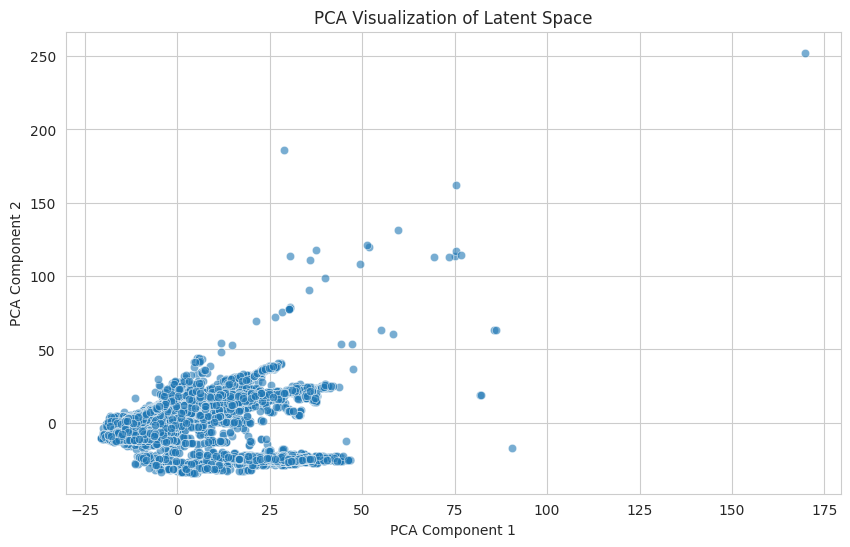

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Getting Encoded Representations
encoded_data = []
autoencoder.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, _, _ = batch
        _, encoded = autoencoder(inputs)
        encoded_data.append(encoded.cpu().numpy())

encoded_data = np.vstack(encoded_data)

# PCA Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(encoded_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], alpha=0.6)
plt.title("PCA Visualization of Latent Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [ ]:
# Dual-output classifier
class DualOutputClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DualOutputClassifier, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 64),  # Removed BatchNorm1d(input_dim)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.binary_head = nn.Linear(32, 1)
        self.multi_head = nn.Linear(32, num_classes)

    def forward(self, x):
        features = self.shared(x)
        binary_output = torch.sigmoid(self.binary_head(features)).squeeze(1)
        multi_output = self.multi_head(features)
        return binary_output, multi_output



from sklearn.utils.class_weight import compute_class_weight

# Computing weights based on frequency of attack classes
class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_attack),
    y=y_attack
)

# Converting to PyTorch tensor
class_weights = torch.tensor(class_weights_np, dtype=torch.float32)

criterion_bin = nn.BCELoss()
criterion_multi = nn.CrossEntropyLoss(weight=class_weights)

# Extracting encoded features from autoencoder
with torch.no_grad():
    X_train_encoded = autoencoder.encoder(X_train).detach()
    X_test_encoded = autoencoder.encoder(X_test).detach()

# Creating new dataset with encoded features
train_dataset = TensorDataset(X_train_encoded, y_anom_train, y_att_train)
test_dataset = TensorDataset(X_test_encoded, y_anom_test, y_att_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

# Updating classifier input dimension
model = DualOutputClassifier(input_dim=32, num_classes=len(attack_encoder.classes_))
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(40):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, target_bin, target_multi = batch
        optimizer.zero_grad()
        output_bin, output_multi = model(inputs)
        loss = criterion_bin(output_bin, target_bin) + criterion_multi(output_multi, target_multi)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Classifier Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Classifier Epoch 1, Loss: 1.4922
Classifier Epoch 2, Loss: 1.0811
Classifier Epoch 3, Loss: 0.9604
Classifier Epoch 4, Loss: 0.9320
Classifier Epoch 5, Loss: 0.8763
Classifier Epoch 6, Loss: 0.8338
Classifier Epoch 7, Loss: 0.8699
Classifier Epoch 8, Loss: 0.8207
Classifier Epoch 9, Loss: 0.7651
Classifier Epoch 10, Loss: 0.7281
Classifier Epoch 11, Loss: 0.7020
Classifier Epoch 12, Loss: 0.8018
Classifier Epoch 13, Loss: 0.7090
Classifier Epoch 14, Loss: 0.6879
Classifier Epoch 15, Loss: 0.6882
Classifier Epoch 16, Loss: 0.6943
Classifier Epoch 17, Loss: 0.7213
Classifier Epoch 18, Loss: 0.6486
Classifier Epoch 19, Loss: 0.6337
Classifier Epoch 20, Loss: 0.6183
Classifier Epoch 21, Loss: 0.6102
Classifier Epoch 22, Loss: 0.6498
Classifier Epoch 23, Loss: 0.5922
Classifier Epoch 24, Loss: 0.5855
Classifier Epoch 25, Loss: 0.5691
Classifier Epoch 26, Loss: 0.5959
Classifier Epoch 27, Loss: 0.5980
Classifier Epoch 28, Loss: 0.5702
Classifier Epoch 29, Loss: 0.5925
Classifier Epoch 30, Lo

In [ ]:
from collections import Counter

# Evaluation
model.eval()
all_bin_preds = []
all_bin_true = []
all_multi_preds = []
all_multi_true = []

with torch.no_grad():
    for batch in test_loader:
        inputs, targets_bin, targets_multi = batch
        out_bin, out_multi = model(inputs)
        pred_bin = (out_bin > 0.5).int()
        pred_multi = torch.argmax(out_multi, dim=1)
        all_bin_preds.extend(pred_bin.tolist())
        all_bin_true.extend(targets_bin.tolist())
        all_multi_preds.extend(pred_multi.tolist())
        all_multi_true.extend(targets_multi.tolist())

# Converting integer labels to attack class names
all_multi_true_labels = attack_encoder.inverse_transform(all_multi_true)
all_multi_pred_labels = attack_encoder.inverse_transform(all_multi_preds)

print("\nAnomaly Detection Report:")
print(classification_report(all_bin_true, all_bin_preds))
print(confusion_matrix(all_bin_true, all_bin_preds))

print("\nAttack Type Classification Report:")
print(classification_report(all_multi_true, all_multi_preds, target_names=attack_encoder.classes_))
print(confusion_matrix(all_multi_true, all_multi_preds))

# Printing class-wise counts
print("\nActual attack class distribution in test set:")
print(dict(Counter(all_multi_true_labels)))

print("\nPredicted attack class distribution:")
print(dict(Counter(all_multi_pred_labels)))



Anomaly Detection Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     15411
         1.0       0.98      0.92      0.95     13543

    accuracy                           0.96     28954
   macro avg       0.96      0.95      0.96     28954
weighted avg       0.96      0.96      0.96     28954

[[15211   200]
 [ 1077 12466]]

Attack Type Classification Report:
              precision    recall  f1-score   support

         DoS       0.99      0.96      0.98     10334
      Normal       0.97      0.81      0.89     15411
       Probe       0.89      0.97      0.93      2552
         R2L       0.21      0.96      0.34       639
         U2R       0.03      0.61      0.06        18

    accuracy                           0.88     28954
   macro avg       0.62      0.86      0.64     28954
weighted avg       0.95      0.88      0.91     28954

[[ 9935   262    86    44     7]
 [   78 12497   221  2315   300]
 [   21    52  2465     

# Upsampling using SMOT

In [ ]:
from imblearn.over_sampling import SMOTE

# Mapping back integer labels to class names
y_att_train_np = y_att_train.numpy()
attack_labels_train = attack_encoder.inverse_transform(y_att_train_np)

# Getting the integer-encoded values for R2L and U2R classes
r2l_label = attack_encoder.transform(['R2L'])[0]
u2r_label = attack_encoder.transform(['U2R'])[0]

# Filterring indices for R2L and U2R
r2l_u2r_mask = np.isin(y_att_train_np, [r2l_label, u2r_label])
non_r2l_u2r_mask = ~r2l_u2r_mask

# Preparing input for SMOTE
X_train_np = X_train.numpy()
X_r2l_u2r = X_train_np[r2l_u2r_mask]
y_r2l_u2r = y_att_train_np[r2l_u2r_mask]

# Only applying SMOTE to R2L and U2R
smote = SMOTE(sampling_strategy={r2l_label: 10000, u2r_label: 8000}, random_state=42)
X_r2l_u2r_res, y_r2l_u2r_res = smote.fit_resample(X_r2l_u2r, y_r2l_u2r)

# Combining with the rest of the original training set
X_combined = np.vstack((X_train_np[non_r2l_u2r_mask], X_r2l_u2r_res))
y_combined = np.hstack((y_att_train_np[non_r2l_u2r_mask], y_r2l_u2r_res))

# Regenerating anomaly labels (0 for Normal, 1 for others)
y_anom_combined = np.array([0 if label == attack_encoder.transform(['Normal'])[0] else 1 for label in y_combined])

# Converting back to tensors
X_train_balanced = torch.tensor(X_combined, dtype=torch.float32)
y_anom_train_balanced = torch.tensor(y_anom_combined, dtype=torch.float32)
y_att_train_balanced = torch.tensor(y_combined, dtype=torch.long)

# Creating updated DataLoader
train_dataset_balanced = TensorDataset(X_train_balanced, y_anom_train_balanced, y_att_train_balanced)
train_loader_balanced = DataLoader(train_dataset_balanced, batch_size=512, shuffle=True)


In [ ]:
from collections import Counter

train_attack_labels = attack_encoder.inverse_transform(y_att_train_balanced.numpy())

attack_class_distribution = dict(Counter(train_attack_labels))

print("Attack class distribution in the augmented training set:")
for label, count in attack_class_distribution.items():
    print(f"{label}: {count}")


Attack class distribution in the augmented training set:
Normal: 61643
DoS: 41334
Probe: 10210
R2L: 10000
U2R: 8000


In [ ]:

# Autoencoder definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Training autoencoder
autoencoder = Autoencoder(X.shape[1])
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion_ae = nn.MSELoss()

for epoch in range(10):
    total_loss = 0
    for batch in train_loader:
        inputs, _, _ = batch
        optimizer_ae.zero_grad()
        outputs, _ = autoencoder(inputs)
        loss = criterion_ae(outputs, inputs)
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item()
    print(f"Autoencoder Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Extracting reduced features
with torch.no_grad():
    X_train_encoded = autoencoder.encoder(X_train)
    X_test_encoded = autoencoder.encoder(X_test)

train_dataset_encoded = TensorDataset(X_train_encoded, y_anom_train, y_att_train)
test_dataset_encoded = TensorDataset(X_test_encoded, y_anom_test, y_att_test)
train_loader_encoded = DataLoader(train_dataset_encoded, batch_size=512, shuffle=True)
test_loader_encoded = DataLoader(test_dataset_encoded, batch_size=512)

# Dual-output classifier
class DualOutputClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DualOutputClassifier, self).__init__()
        self.shared = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.binary_head = nn.Linear(32, 1)
        self.multi_head = nn.Linear(32, num_classes)

    def forward(self, x):
        features = self.shared(x)
        binary_output = torch.sigmoid(self.binary_head(features)).squeeze(1)
        multi_output = self.multi_head(features)
        return binary_output, multi_output


from sklearn.utils.class_weight import compute_class_weight

# Computing weights based on frequency of attack classes
class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_attack),
    y=y_attack
)

# Converting to PyTorch tensor
class_weights = torch.tensor(class_weights_np, dtype=torch.float32)


model = DualOutputClassifier(input_dim=32, num_classes=len(attack_encoder.classes_))
criterion_bin = nn.BCELoss()
criterion_multi = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training classifier
for epoch in range(40):
    model.train()
    total_loss = 0
    for batch in train_loader_encoded:
        inputs, target_bin, target_multi = batch
        optimizer.zero_grad()
        output_bin, output_multi = model(inputs)
        loss = criterion_bin(output_bin, target_bin) + criterion_multi(output_multi, target_multi)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Classifier Epoch {epoch+1}, Loss: {total_loss / len(train_loader_encoded):.4f}")

Autoencoder Epoch 1, Loss: 1.0208
Autoencoder Epoch 2, Loss: 1.0009
Autoencoder Epoch 3, Loss: 0.9985
Autoencoder Epoch 4, Loss: 0.9864
Autoencoder Epoch 5, Loss: 0.9709
Autoencoder Epoch 6, Loss: 0.9705
Autoencoder Epoch 7, Loss: 1.0044
Autoencoder Epoch 8, Loss: 0.9695
Autoencoder Epoch 9, Loss: 0.9699
Autoencoder Epoch 10, Loss: 0.9695
Classifier Epoch 1, Loss: 1.4646
Classifier Epoch 2, Loss: 1.0877
Classifier Epoch 3, Loss: 1.0024
Classifier Epoch 4, Loss: 0.9083
Classifier Epoch 5, Loss: 0.8596
Classifier Epoch 6, Loss: 0.8192
Classifier Epoch 7, Loss: 0.7677
Classifier Epoch 8, Loss: 0.7216
Classifier Epoch 9, Loss: 0.7135
Classifier Epoch 10, Loss: 0.6702
Classifier Epoch 11, Loss: 0.6367
Classifier Epoch 12, Loss: 0.6189
Classifier Epoch 13, Loss: 0.6098
Classifier Epoch 14, Loss: 0.6046
Classifier Epoch 15, Loss: 0.5842
Classifier Epoch 16, Loss: 0.5620
Classifier Epoch 17, Loss: 0.5593
Classifier Epoch 18, Loss: 0.5437
Classifier Epoch 19, Loss: 0.5399
Classifier Epoch 20, L

In [ ]:
from collections import Counter

# Evaluation
model.eval()
all_bin_preds = []
all_bin_true = []
all_multi_preds = []
all_multi_true = []

with torch.no_grad():
    for batch in test_loader_encoded:
        inputs, targets_bin, targets_multi = batch
        out_bin, out_multi = model(inputs)
        pred_bin = (out_bin > 0.5).int()
        pred_multi = torch.argmax(out_multi, dim=1)
        all_bin_preds.extend(pred_bin.tolist())
        all_bin_true.extend(targets_bin.tolist())
        all_multi_preds.extend(pred_multi.tolist())
        all_multi_true.extend(targets_multi.tolist())

# Converting integer labels to attack class names
all_multi_true_labels = attack_encoder.inverse_transform(all_multi_true)
all_multi_pred_labels = attack_encoder.inverse_transform(all_multi_preds)

print("\nAnomaly Detection Report:")
print(classification_report(all_bin_true, all_bin_preds))
print(confusion_matrix(all_bin_true, all_bin_preds))

print("\nAttack Type Classification Report:")
print(classification_report(all_multi_true, all_multi_preds, target_names=attack_encoder.classes_))
print(confusion_matrix(all_multi_true, all_multi_preds))

print("\nActual attack class distribution in test set:")
print(dict(Counter(all_multi_true_labels)))

print("\nPredicted attack class distribution:")
print(dict(Counter(all_multi_pred_labels)))



Anomaly Detection Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     15411
         1.0       0.98      0.94      0.96     13543

    accuracy                           0.96     28954
   macro avg       0.97      0.96      0.96     28954
weighted avg       0.96      0.96      0.96     28954

[[15175   236]
 [  818 12725]]

Attack Type Classification Report:
              precision    recall  f1-score   support

         DoS       0.99      0.93      0.96     10334
      Normal       0.97      0.90      0.93     15411
       Probe       0.82      0.94      0.88      2552
         R2L       0.54      0.92      0.68       639
         U2R       0.02      0.83      0.03        18

    accuracy                           0.92     28954
   macro avg       0.67      0.91      0.70     28954
weighted avg       0.95      0.92      0.93     28954

[[ 9640   313   274    35    72]
 [   56 13854   241   453   807]
 [   33    86  2398    1

# Upsampling using VAE

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Loading and merge train/test .txt files
df_train = pd.read_csv("Train.txt", header=None)
df_test = pd.read_csv("Test.txt", header=None)
df = pd.concat([df_train, df_test], ignore_index=True)

# Assigning column names manually (last column is 'attack')
df.columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "attack", "last_flag"
]

# Mapping detailed attacks to high-level categories
attack_mapping = {
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L',
    'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
    'normal': 'Normal'
}

# Applying mapping
df['attack_class'] = df['attack'].map(attack_mapping)
df = df[df['attack_class'].notnull()]  # Drop unknown attacks

# Creating binary anomaly label
df['is_anomaly'] = df['attack_class'].apply(lambda x: 0 if x == 'Normal' else 1)

# Encoding categorical columns
df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])

# Encoding multi-class target
attack_encoder = LabelEncoder()
df['attack_class_encoded'] = attack_encoder.fit_transform(df['attack_class'])

# Preparing features and labels
features = df.drop(columns=['attack', 'attack_class', 'attack_class_encoded', 'is_anomaly', 'last_flag'])
X = StandardScaler().fit_transform(features.values)
y_anomaly = df['is_anomaly'].values
y_attack = df['attack_class_encoded'].values

X_tensor = torch.tensor(X, dtype=torch.float32)
y_anomaly_tensor = torch.tensor(y_anomaly, dtype=torch.float32)
y_attack_tensor = torch.tensor(y_attack, dtype=torch.long)

X_train, X_test, y_anom_train, y_anom_test, y_att_train, y_att_test = train_test_split(
    X_tensor, y_anomaly_tensor, y_attack_tensor, test_size=0.2, stratify=y_attack_tensor, random_state=42
)

train_dataset = TensorDataset(X_train, y_anom_train, y_att_train)
test_dataset = TensorDataset(X_test, y_anom_test, y_att_test)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

<ipython-input-38-1ef8d5c101c6>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_anomaly'] = df['attack_class'].apply(lambda x: 0 if x == 'Normal' else 1)


In [ ]:
train_labels, train_counts = np.unique(y_att_train.numpy(), return_counts=True)
test_labels, test_counts = np.unique(y_att_test.numpy(), return_counts=True)

train_distribution = {attack_encoder.classes_[i]: train_counts[i] for i in range(len(train_labels))}
test_distribution = {attack_encoder.classes_[i]: test_counts[i] for i in range(len(test_labels))}

print("Train Data Attack Class Distribution:")
print(train_distribution)
print("\nTest Data Attack Class Distribution:")
print(test_distribution)


Train Data Attack Class Distribution:
{'DoS': np.int64(41334), 'Normal': np.int64(61643), 'Probe': np.int64(10210), 'R2L': np.int64(2555), 'U2R': np.int64(71)}

Test Data Attack Class Distribution:
{'DoS': np.int64(10334), 'Normal': np.int64(15411), 'Probe': np.int64(2552), 'R2L': np.int64(639), 'U2R': np.int64(18)}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Define VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, latent_dim)
        self.log_var = nn.Linear(32, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = self.mu(h), self.log_var(h)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

def train_vae(X_train, epochs=50, batch_size=32, latent_dim=10):
    input_dim = X_train.shape[1]
    vae = VAE(input_dim, latent_dim)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)
    loss_function = nn.MSELoss()

    dataset = TensorDataset(X_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            x = batch[0]
            optimizer.zero_grad()
            recon_x, mu, log_var = vae(x)

            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = loss_function(recon_x, x) + kl_div
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

    return vae

# generating synthetic data
def generate_synthetic_data(vae, num_samples):
    latent_dim = vae.mu.out_features
    z = torch.randn(num_samples, latent_dim)
    synthetic_samples = vae.decoder(z).detach().numpy()
    return synthetic_samples

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['attack_class'], random_state=42)

# Upsampling U2R and R2L classes only in training set
for attack_class, target_count in [('U2R', 6000), ('R2L', 9000)]:
    class_data = df_train[df_train['attack_class'] == attack_class]
    X_class = torch.tensor(StandardScaler().fit_transform(class_data.drop(columns=['attack', 'attack_class', 'attack_class_encoded', 'is_anomaly', 'last_flag']).values), dtype=torch.float32)
    vae = train_vae(X_class)

    num_samples_to_generate = target_count - len(class_data)
    synthetic_data = generate_synthetic_data(vae, num_samples_to_generate)

    synthetic_df = pd.DataFrame(synthetic_data, columns=df_train.drop(columns=['attack', 'attack_class', 'attack_class_encoded', 'is_anomaly', 'last_flag']).columns)
    synthetic_df['attack_class'] = attack_class
    synthetic_df['attack_class_encoded'] = attack_encoder.transform(synthetic_df['attack_class'])
    synthetic_df['is_anomaly'] = 1

    df_train = pd.concat([df_train, synthetic_df], ignore_index=True)

# Combining train and test without modifying test data
df_augmented = pd.concat([df_train, df_test], ignore_index=True)
print("New dataset shape after augmentation:", df_augmented.shape)



Epoch 0, Loss: 5.4064
Epoch 10, Loss: 1.2162
Epoch 20, Loss: 1.1317
Epoch 30, Loss: 0.9738
Epoch 40, Loss: 1.1537
Epoch 0, Loss: 79.8346
Epoch 10, Loss: 35.0733
Epoch 20, Loss: 34.8713
Epoch 30, Loss: 34.9524
Epoch 40, Loss: 34.9365
New dataset shape after augmentation: (157141, 127)


In [ ]:
print("Attack class distribution after upsampling:")
print(df_augmented['attack_class'].value_counts())

Attack class distribution after upsampling:
attack_class
Normal    77054
DoS       51668
Probe     12762
R2L        9639
U2R        6018
Name: count, dtype: int64


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

features_train = df_train.drop(columns=['attack', 'attack_class', 'attack_class_encoded', 'is_anomaly', 'last_flag']).values
features_test = df_test.drop(columns=['attack', 'attack_class', 'attack_class_encoded', 'is_anomaly', 'last_flag']).values

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(features_train)
X_test_scaled = scaler.transform(features_test)

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

autoencoder = Autoencoder(X_train_tensor.shape[1])
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion_ae = nn.MSELoss()

for epoch in range(30):
    total_loss = 0
    for batch in train_loader:
        inputs = batch[0]
        optimizer_ae.zero_grad()
        outputs, _ = autoencoder(inputs)
        loss = criterion_ae(outputs, inputs)
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item()
    print(f"Autoencoder Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Extracting reduced features
with torch.no_grad():
    X_train_encoded = autoencoder.encoder(X_train_tensor)
    X_test_encoded = autoencoder.encoder(X_test_tensor)

print("\nAutoencoder Training Complete. Encoded feature dimension:", X_train_encoded.shape[1])


Autoencoder Epoch 1, Loss: 1.0208
Autoencoder Epoch 2, Loss: 1.0000
Autoencoder Epoch 3, Loss: 0.9998
Autoencoder Epoch 4, Loss: 0.9994
Autoencoder Epoch 5, Loss: 1.0000
Autoencoder Epoch 6, Loss: 0.9907
Autoencoder Epoch 7, Loss: 0.9513
Autoencoder Epoch 8, Loss: 0.9480
Autoencoder Epoch 9, Loss: 0.9475
Autoencoder Epoch 10, Loss: 0.9471
Autoencoder Epoch 11, Loss: 0.9470
Autoencoder Epoch 12, Loss: 0.9468
Autoencoder Epoch 13, Loss: 0.9469
Autoencoder Epoch 14, Loss: 0.9457
Autoencoder Epoch 15, Loss: 0.9427
Autoencoder Epoch 16, Loss: 0.9406
Autoencoder Epoch 17, Loss: 0.9403
Autoencoder Epoch 18, Loss: 0.9404
Autoencoder Epoch 19, Loss: 0.9405
Autoencoder Epoch 20, Loss: 0.9378
Autoencoder Epoch 21, Loss: 0.9345
Autoencoder Epoch 22, Loss: 0.9339
Autoencoder Epoch 23, Loss: 0.9338
Autoencoder Epoch 24, Loss: 0.9336
Autoencoder Epoch 25, Loss: 0.9334
Autoencoder Epoch 26, Loss: 0.9323
Autoencoder Epoch 27, Loss: 0.9339
Autoencoder Epoch 28, Loss: 0.9315
Autoencoder Epoch 29, Loss: 0

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Define Dual-output classifier
class DualOutputClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DualOutputClassifier, self).__init__()
        self.shared = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.binary_head = nn.Linear(32, 1)
        self.multi_head = nn.Linear(32, num_classes)

    def forward(self, x):
        features = self.shared(x)
        binary_output = torch.sigmoid(self.binary_head(features)).squeeze(1)
        multi_output = self.multi_head(features)
        return binary_output, multi_output

# Preparing labels
y_train_anomaly = df_train['is_anomaly'].values
y_train_attack = df_train['attack_class_encoded'].values
y_test_anomaly = df_test['is_anomaly'].values
y_test_attack = df_test['attack_class_encoded'].values

# Converting to tensors
y_train_anomaly_tensor = torch.tensor(y_train_anomaly, dtype=torch.float32)
y_train_attack_tensor = torch.tensor(y_train_attack, dtype=torch.long)
y_test_anomaly_tensor = torch.tensor(y_test_anomaly, dtype=torch.float32)
y_test_attack_tensor = torch.tensor(y_test_attack, dtype=torch.long)

# Preparing data loaders
train_dataset_encoded = TensorDataset(X_train_encoded, y_train_anomaly_tensor, y_train_attack_tensor)
test_dataset_encoded = TensorDataset(X_test_encoded, y_test_anomaly_tensor, y_test_attack_tensor)
train_loader_encoded = DataLoader(train_dataset_encoded, batch_size=512, shuffle=True)
test_loader_encoded = DataLoader(test_dataset_encoded, batch_size=512)

# Computing class weights for attack classification
class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_attack),
    y=y_train_attack
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32)

# Initializing model
model = DualOutputClassifier(input_dim=32, num_classes=len(np.unique(y_train_attack)))
criterion_bin = nn.BCELoss()
criterion_multi = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(40):
    model.train()
    total_loss = 0
    for batch in train_loader_encoded:
        inputs, target_bin, target_multi = batch
        optimizer.zero_grad()
        output_bin, output_multi = model(inputs)
        loss = criterion_bin(output_bin, target_bin) + criterion_multi(output_multi, target_multi)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Classifier Epoch {epoch+1}, Loss: {total_loss / len(train_loader_encoded):.4f}")

print("\nClassifier Training Complete.")


Classifier Epoch 1, Loss: 0.8361
Classifier Epoch 2, Loss: 0.3834
Classifier Epoch 3, Loss: 0.3304
Classifier Epoch 4, Loss: 0.3010
Classifier Epoch 5, Loss: 0.2840
Classifier Epoch 6, Loss: 0.2647
Classifier Epoch 7, Loss: 0.2580
Classifier Epoch 8, Loss: 0.2469
Classifier Epoch 9, Loss: 0.2374
Classifier Epoch 10, Loss: 0.2304
Classifier Epoch 11, Loss: 0.2257
Classifier Epoch 12, Loss: 0.2184
Classifier Epoch 13, Loss: 0.2156
Classifier Epoch 14, Loss: 0.2111
Classifier Epoch 15, Loss: 0.2079
Classifier Epoch 16, Loss: 0.2026
Classifier Epoch 17, Loss: 0.1989
Classifier Epoch 18, Loss: 0.1956
Classifier Epoch 19, Loss: 0.1933
Classifier Epoch 20, Loss: 0.1922
Classifier Epoch 21, Loss: 0.1917
Classifier Epoch 22, Loss: 0.1864
Classifier Epoch 23, Loss: 0.1827
Classifier Epoch 24, Loss: 0.1825
Classifier Epoch 25, Loss: 0.1772
Classifier Epoch 26, Loss: 0.1792
Classifier Epoch 27, Loss: 0.1782
Classifier Epoch 28, Loss: 0.1722
Classifier Epoch 29, Loss: 0.1717
Classifier Epoch 30, Lo

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# Evaluation
model.eval()
all_bin_preds = []
all_bin_true = []
all_multi_preds = []
all_multi_true = []

with torch.no_grad():
    for batch in test_loader_encoded:
        inputs, targets_bin, targets_multi = batch
        out_bin, out_multi = model(inputs)
        pred_bin = (out_bin > 0.5).int()
        pred_multi = torch.argmax(out_multi, dim=1)
        all_bin_preds.extend(pred_bin.tolist())
        all_bin_true.extend(targets_bin.tolist())
        all_multi_preds.extend(pred_multi.tolist())
        all_multi_true.extend(targets_multi.tolist())

all_multi_true_labels = attack_encoder.inverse_transform(all_multi_true)
all_multi_pred_labels = attack_encoder.inverse_transform(all_multi_preds)

print("\nAnomaly Detection Report:")
print(classification_report(all_bin_true, all_bin_preds))
print("Confusion Matrix (Anomaly Detection):")
print(confusion_matrix(all_bin_true, all_bin_preds))

print("\nAttack Type Classification Report:")
print(classification_report(all_multi_true, all_multi_preds, target_names=attack_encoder.classes_))
print("Confusion Matrix (Attack Classification):")
print(confusion_matrix(all_multi_true, all_multi_preds))

print("\nActual attack class distribution in test set:")
print(dict(Counter(all_multi_true_labels)))

print("\nPredicted attack class distribution:")
print(dict(Counter(all_multi_pred_labels)))



Anomaly Detection Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     15411
         1.0       0.99      0.96      0.97     13543

    accuracy                           0.97     28954
   macro avg       0.98      0.97      0.97     28954
weighted avg       0.97      0.97      0.97     28954

Confusion Matrix (Anomaly Detection):
[[15234   177]
 [  571 12972]]

Attack Type Classification Report:
              precision    recall  f1-score   support

         DoS       0.99      0.97      0.98     10334
      Normal       0.97      0.96      0.97     15411
       Probe       0.88      0.99      0.93      2552
         R2L       0.69      0.84      0.76       639
         U2R       0.69      0.50      0.58        18

    accuracy                           0.96     28954
   macro avg       0.85      0.85      0.84     28954
weighted avg       0.97      0.96      0.96     28954

Confusion Matrix (Attack Classification):
[[ 9990   

# Hyperparameter finetuning on VAE sampling

Training with lr=0.001, batch_size=256, dropout=0.3, hidden_sizes=(64,32)
Validation Accuracy: 0.9398
Training with lr=0.001, batch_size=256, dropout=0.3, hidden_sizes=(128,64)
Validation Accuracy: 0.9453
Training with lr=0.001, batch_size=256, dropout=0.5, hidden_sizes=(64,32)
Validation Accuracy: 0.9409
Training with lr=0.001, batch_size=256, dropout=0.5, hidden_sizes=(128,64)
Validation Accuracy: 0.9429
Training with lr=0.001, batch_size=512, dropout=0.3, hidden_sizes=(64,32)
Validation Accuracy: 0.9408
Training with lr=0.001, batch_size=512, dropout=0.3, hidden_sizes=(128,64)
Validation Accuracy: 0.9514
Training with lr=0.001, batch_size=512, dropout=0.5, hidden_sizes=(64,32)
Validation Accuracy: 0.9294
Training with lr=0.001, batch_size=512, dropout=0.5, hidden_sizes=(128,64)
Validation Accuracy: 0.9466
Training with lr=0.001, batch_size=1024, dropout=0.3, hidden_sizes=(64,32)
Validation Accuracy: 0.9160
Training with lr=0.001, batch_size=1024, dropout=0.3, hidden_sizes=(128,64)
V

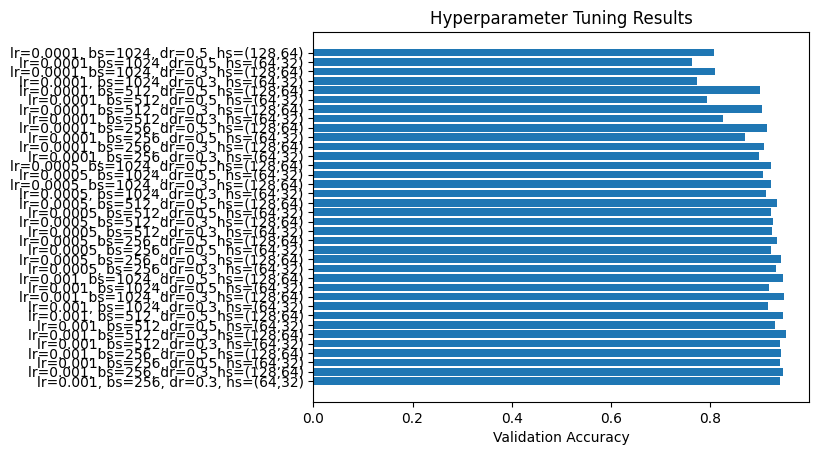

Best Hyperparameters: lr=0.001, batch_size=512, dropout=0.3, hidden_sizes=(128,64)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import accuracy_score

# Defining hyperparameter grid
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [256, 512, 1024]
dropout_rates = [0.3, 0.5]
hidden_sizes = [(64, 32), (128, 64)]

best_model = None
best_accuracy = 0
best_params = None
results = []

# Perform grid search
for lr, batch_size, dropout, (h1, h2) in product(learning_rates, batch_sizes, dropout_rates, hidden_sizes):
    print(f"Training with lr={lr}, batch_size={batch_size}, dropout={dropout}, hidden_sizes=({h1},{h2})")

    train_loader = DataLoader(train_dataset_encoded, batch_size=batch_size, shuffle=True)

    class DualOutputClassifier(nn.Module):
        def __init__(self, input_dim, num_classes, h1, h2, dropout):
            super(DualOutputClassifier, self).__init__()
            self.shared = nn.Sequential(
                nn.BatchNorm1d(input_dim),
                nn.Linear(input_dim, h1),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(h1, h2),
                nn.ReLU()
            )
            self.binary_head = nn.Linear(h2, 1)
            self.multi_head = nn.Linear(h2, num_classes)

        def forward(self, x):
            features = self.shared(x)
            binary_output = torch.sigmoid(self.binary_head(features)).squeeze(1)
            multi_output = self.multi_head(features)
            return binary_output, multi_output

    model = DualOutputClassifier(input_dim=32, num_classes=len(np.unique(y_train_attack)), h1=h1, h2=h2, dropout=dropout)
    criterion_bin = nn.BCELoss()
    criterion_multi = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(10):  # Run for fewer epochs in search
        model.train()
        for batch in train_loader:
            inputs, target_bin, target_multi = batch
            optimizer.zero_grad()
            output_bin, output_multi = model(inputs)
            loss = criterion_bin(output_bin, target_bin) + criterion_multi(output_multi, target_multi)
            loss.backward()
            optimizer.step()

    model.eval()
    all_bin_preds, all_bin_true, all_multi_preds, all_multi_true = [], [], [], []
    with torch.no_grad():
        for batch in test_loader_encoded:
            inputs, targets_bin, targets_multi = batch
            out_bin, out_multi = model(inputs)
            all_bin_preds.extend((out_bin > 0.5).int().tolist())
            all_bin_true.extend(targets_bin.tolist())
            all_multi_preds.extend(torch.argmax(out_multi, dim=1).tolist())
            all_multi_true.extend(targets_multi.tolist())

    accuracy = accuracy_score(all_multi_true, all_multi_preds)
    results.append((lr, batch_size, dropout, h1, h2, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_params = (lr, batch_size, dropout, h1, h2)

    print(f"Validation Accuracy: {accuracy:.4f}")

# Visualizing results
fig, ax = plt.subplots()
accuracies = [res[-1] for res in results]
x_labels = [f"lr={res[0]}, bs={res[1]}, dr={res[2]}, hs=({res[3]},{res[4]})" for res in results]
ax.barh(x_labels, accuracies)
ax.set_xlabel("Validation Accuracy")
ax.set_title("Hyperparameter Tuning Results")
plt.show()

print(f"Best Hyperparameters: lr={best_params[0]}, batch_size={best_params[1]}, dropout={best_params[2]}, hidden_sizes=({best_params[3]},{best_params[4]})")


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class DualOutputClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DualOutputClassifier, self).__init__()
        self.shared = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.binary_head = nn.Linear(32, 1)
        self.multi_head = nn.Linear(32, num_classes)

    def forward(self, x):
        features = self.shared(x)
        binary_output = torch.sigmoid(self.binary_head(features)).squeeze(1)
        multi_output = self.multi_head(features)
        return binary_output, multi_output

y_train_anomaly = df_train['is_anomaly'].values
y_train_attack = df_train['attack_class_encoded'].values
y_test_anomaly = df_test['is_anomaly'].values
y_test_attack = df_test['attack_class_encoded'].values

y_train_anomaly_tensor = torch.tensor(y_train_anomaly, dtype=torch.float32)
y_train_attack_tensor = torch.tensor(y_train_attack, dtype=torch.long)
y_test_anomaly_tensor = torch.tensor(y_test_anomaly, dtype=torch.float32)
y_test_attack_tensor = torch.tensor(y_test_attack, dtype=torch.long)

train_dataset_encoded = TensorDataset(X_train_encoded, y_train_anomaly_tensor, y_train_attack_tensor)
test_dataset_encoded = TensorDataset(X_test_encoded, y_test_anomaly_tensor, y_test_attack_tensor)
train_loader_encoded = DataLoader(train_dataset_encoded, batch_size=512, shuffle=True)
test_loader_encoded = DataLoader(test_dataset_encoded, batch_size=512)

class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_attack),
    y=y_train_attack
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32)

model = DualOutputClassifier(input_dim=32, num_classes=len(np.unique(y_train_attack)))
criterion_bin = nn.BCELoss()
criterion_multi = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)




In [ ]:
learning_rate = 0.001
batch_size = 512
dropout = 0.3
hidden_sizes = (128,64)

class DualOutputClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, h1, h2, dropout):
        super(DualOutputClassifier, self).__init__()
        self.shared = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU()
        )
        self.binary_head = nn.Linear(h2, 1)
        self.multi_head = nn.Linear(h2, num_classes)

    def forward(self, x):
        features = self.shared(x)
        binary_output = torch.sigmoid(self.binary_head(features)).squeeze(1)
        multi_output = self.multi_head(features)
        return binary_output, multi_output

model = DualOutputClassifier(input_dim=32, num_classes=len(np.unique(y_train_attack)), h1=h1, h2=h2, dropout=dropout)
criterion_bin = nn.BCELoss()
criterion_multi = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(40):
    model.train()
    total_loss = 0
    for batch in train_loader_encoded:
        inputs, target_bin, target_multi = batch
        optimizer.zero_grad()
        output_bin, output_multi = model(inputs)
        loss = criterion_bin(output_bin, target_bin) + criterion_multi(output_multi, target_multi)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Classifier Epoch {epoch+1}, Loss: {total_loss / len(train_loader_encoded):.4f}")

print("\nClassifier Training Complete.")

Classifier Epoch 1, Loss: 0.9377
Classifier Epoch 2, Loss: 0.5504
Classifier Epoch 3, Loss: 0.4748
Classifier Epoch 4, Loss: 0.4224
Classifier Epoch 5, Loss: 0.3868
Classifier Epoch 6, Loss: 0.3568
Classifier Epoch 7, Loss: 0.3354
Classifier Epoch 8, Loss: 0.3205
Classifier Epoch 9, Loss: 0.3066
Classifier Epoch 10, Loss: 0.2909
Classifier Epoch 11, Loss: 0.2848
Classifier Epoch 12, Loss: 0.2757
Classifier Epoch 13, Loss: 0.2666
Classifier Epoch 14, Loss: 0.2668
Classifier Epoch 15, Loss: 0.2564
Classifier Epoch 16, Loss: 0.2502
Classifier Epoch 17, Loss: 0.2479
Classifier Epoch 18, Loss: 0.2410
Classifier Epoch 19, Loss: 0.2377
Classifier Epoch 20, Loss: 0.2319
Classifier Epoch 21, Loss: 0.2281
Classifier Epoch 22, Loss: 0.2272
Classifier Epoch 23, Loss: 0.2220
Classifier Epoch 24, Loss: 0.2250
Classifier Epoch 25, Loss: 0.2194
Classifier Epoch 26, Loss: 0.2191
Classifier Epoch 27, Loss: 0.2175
Classifier Epoch 28, Loss: 0.2147
Classifier Epoch 29, Loss: 0.2126
Classifier Epoch 30, Lo

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# Evaluation
model.eval()
all_bin_preds = []
all_bin_true = []
all_multi_preds = []
all_multi_true = []

with torch.no_grad():
    for batch in test_loader_encoded:
        inputs, targets_bin, targets_multi = batch
        out_bin, out_multi = model(inputs)
        pred_bin = (out_bin > 0.5).int()
        pred_multi = torch.argmax(out_multi, dim=1)
        all_bin_preds.extend(pred_bin.tolist())
        all_bin_true.extend(targets_bin.tolist())
        all_multi_preds.extend(pred_multi.tolist())
        all_multi_true.extend(targets_multi.tolist())

all_multi_true_labels = attack_encoder.inverse_transform(all_multi_true)
all_multi_pred_labels = attack_encoder.inverse_transform(all_multi_preds)

print("\nAnomaly Detection Report:")
print(classification_report(all_bin_true, all_bin_preds))
print("Confusion Matrix (Anomaly Detection):")
print(confusion_matrix(all_bin_true, all_bin_preds))

print("\nAttack Type Classification Report:")
print(classification_report(all_multi_true, all_multi_preds, target_names=attack_encoder.classes_))
print("Confusion Matrix (Attack Classification):")
print(confusion_matrix(all_multi_true, all_multi_preds))

print("\nActual attack class distribution in test set:")
print(dict(Counter(all_multi_true_labels)))

print("\nPredicted attack class distribution:")
print(dict(Counter(all_multi_pred_labels)))



Anomaly Detection Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.97     15411
         1.0       0.98      0.96      0.97     13543

    accuracy                           0.97     28954
   macro avg       0.97      0.97      0.97     28954
weighted avg       0.97      0.97      0.97     28954

Confusion Matrix (Anomaly Detection):
[[15181   230]
 [  550 12993]]

Attack Type Classification Report:
              precision    recall  f1-score   support

         DoS       0.99      0.97      0.98     10334
      Normal       0.98      0.96      0.97     15411
       Probe       0.89      0.98      0.93      2552
         R2L       0.63      0.90      0.74       639
         U2R       0.29      0.61      0.39        18

    accuracy                           0.96     28954
   macro avg       0.76      0.88      0.80     28954
weighted avg       0.97      0.96      0.96     28954

Confusion Matrix (Attack Classification):
[[10040   

# Using Transformer

In [ ]:
#importing the dependancies
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
#defining the model
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads=8, ff_dim=2048, dropout=0.1):
        super(TransformerBlock, self).__init__()
        #this layer computes attention between different parts of input
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)#multi-head attention layer
        #feed-forward network (two linear layers with a ReLU in between)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),#first linear layer (expanding dimensions)
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)#second linear layer (compressing dimensions back to embed_dim)
        )
        self.layer_norm1 = nn.LayerNorm(embed_dim)# layer normalization layers to stabilize training
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout) # applying dropout to regularize the model

    def forward(self, x):
        # Attention layer
        attn_output, _ = self.attn(x, x, x)# the attention output is computed
        x = self.layer_norm1(x + self.dropout(attn_output))  # adding the attention output and applying layer norm with residual connection

        # Feed-forward network
        ff_output = self.ff(x)# the input goes through the feed-forward network
        x = self.layer_norm2(x + self.dropout(ff_output))

        return x



In [ ]:


class TabularAnomalyDetector(nn.Module):
    def __init__(self, num_features, hidden_dims=[512, 256, 128, 64], num_classes=2, embed_dim=64, num_heads=4):
        super(TabularAnomalyDetector, self).__init__()

        #initial dense layers
        layers = []
        in_dim = num_features
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
            in_dim = h_dim

        self.fc = nn.Sequential(*layers)#combining all layers into a sequential block

        self.transformer = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads)

        self.output_layer = nn.Linear(hidden_dims[-1], num_classes)  # Now using the final hidden_dim as input

    def forward(self, x):
        x = self.fc(x)

        #reshape the output to fit the transformer (adding sequence length dimension)
        x = x.unsqueeze(0)  # add an extra dimension to represent sequence length (batch_size, seq_length, embed_dim)

        x = self.transformer(x)

        ## output layer (final logits)
        logits = self.output_layer(x.squeeze(0))  #reemoving the sequence length dimension
        return logits

class AttackClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=64, num_heads=4):
        super(AttackClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        #additional Linear Layer to match embedding dimension for transformer
        self.fc_transformer = nn.Linear(128, embed_dim)  #ensuring the output size is `embed_dim`

        self.transformer = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads)

        self.fc4 = nn.Linear(embed_dim, num_classes)  #output layer after transformer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        #linear transformation to match the embedding dimension for the transformer
        x = self.fc_transformer(x)

        x = x.unsqueeze(0)#shape: (1, batch_size, embed_dim)

        x = self.transformer(x)

        x = self.fc4(x.squeeze(0))
        return x

In [ ]:
df_train = pd.read_csv("Train.txt", header=None)
df_test = pd.read_csv("Test.txt", header=None)
df = pd.concat([df_train, df_test], ignore_index=True)

#assign column names
df.columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "attack", "last_flag"
]

#map attack types to high-level categories
attack_mapping = {
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L',
    'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
    'normal': 'Normal'
}



In [ ]:
df['attack_class'] = df['attack'].map(attack_mapping)
df = df[df['attack_class'].notnull()]  #drop unknown attacks

#create binary anomaly label
df.loc[:, 'is_anomaly'] = df['attack_class'].apply(lambda x: 0 if x == 'Normal' else 1)

#encode categorical columns
df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])

In [ ]:
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,1,20,9,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal,20
1,0,2,44,9,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal,15
2,0,1,49,5,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS,19
3,0,1,24,9,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal,21
4,0,1,24,9,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal,21


<ipython-input-15-23d9fbac6a85>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_attacks.index, y=top_5_attacks.values, palette='Set2')


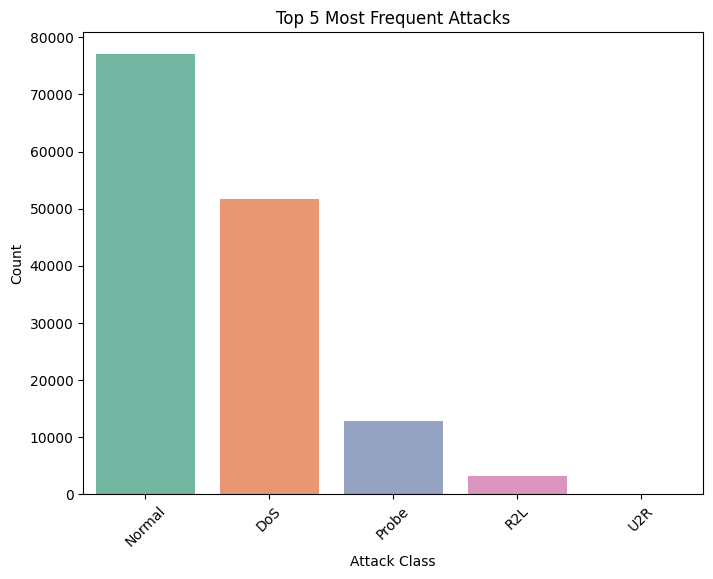

In [ ]:
attack_counts = df['attack_class'].value_counts()
top_5_attacks = attack_counts.head(5)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_5_attacks.index, y=top_5_attacks.values, palette='Set2')
plt.title('Top 5 Most Frequent Attacks')
plt.xlabel('Attack Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


<ipython-input-23-be837d2f9e44>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='attack', data=df, palette='Set3', order=df['attack'].value_counts().index)


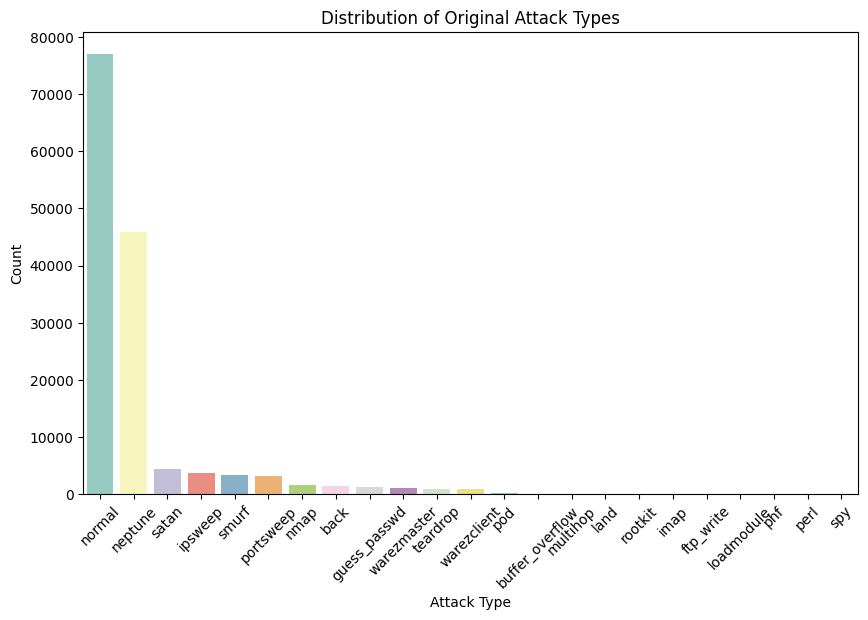

In [ ]:
#visualizing the distribution of the original 'attack' types
plt.figure(figsize=(10, 6))
sns.countplot(x='attack', data=df, palette='Set3', order=df['attack'].value_counts().index)
plt.title('Distribution of Original Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


<ipython-input-25-20ac6dbe0094>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_anomaly', data=df, palette='coolwarm')


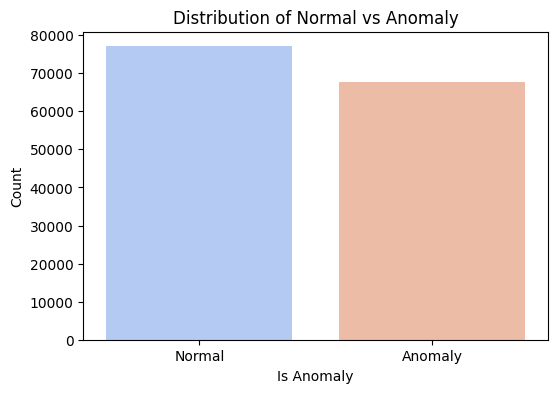

In [ ]:
# Visualizing the distribution of normal vs anomaly
plt.figure(figsize=(6, 4))
sns.countplot(x='is_anomaly', data=df, palette='coolwarm')
plt.title('Distribution of Normal vs Anomaly')
plt.xlabel('Is Anomaly')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Anomaly'])
plt.show()


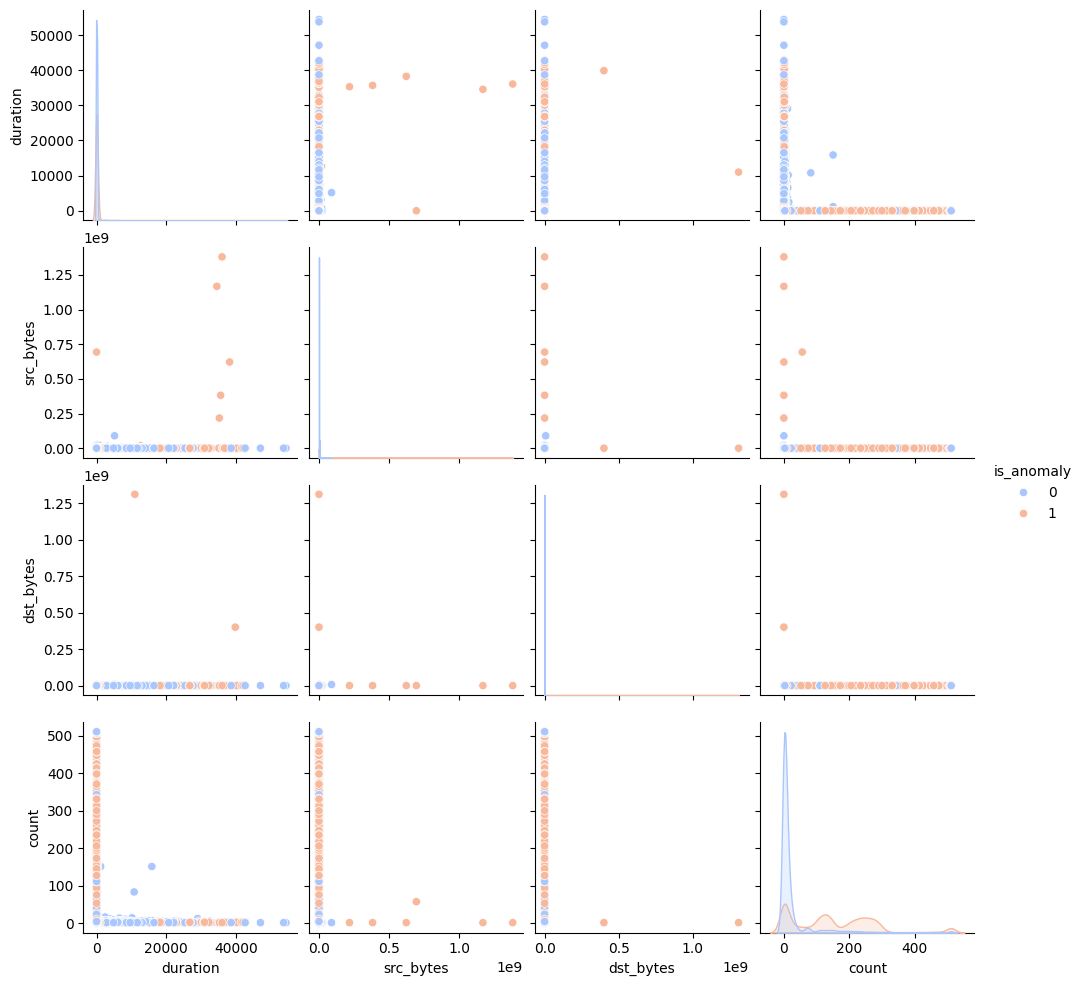

In [ ]:
#visualizing pairplot for key features to see their relationship with 'is_anomaly'
sns.pairplot(df[['duration', 'src_bytes', 'dst_bytes', 'count', 'is_anomaly']], hue='is_anomaly', palette='coolwarm')
plt.show()


In [ ]:
#split into train and test sets stratified by 'is_anomaly'
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['is_anomaly'], random_state=42)

#prepare data for anomaly detector
X_train_ad_raw = train_df.drop(columns=['attack', 'attack_class', 'is_anomaly', 'last_flag']).values
y_train_ad = train_df['is_anomaly'].values
X_test_ad_raw = test_df.drop(columns=['attack', 'attack_class', 'is_anomaly', 'last_flag']).values
y_test_ad = test_df['is_anomaly'].values

#scale features for anomaly detector
scaler_ad = StandardScaler()
X_train_ad = scaler_ad.fit_transform(X_train_ad_raw)
X_test_ad = scaler_ad.transform(X_test_ad_raw)

#prepare data for attack classifier (only anomaly samples)
#training data for attack classifier
train_anomaly_mask = (train_df['is_anomaly'] == 1)
X_train_ac = X_train_ad[train_anomaly_mask]
y_train_ac = train_df.loc[train_anomaly_mask, 'attack_class'].values

#test data for attack classifier
test_anomaly_mask = (test_df['is_anomaly'] == 1)
X_test_ac = X_test_ad[test_anomaly_mask]
y_test_ac = test_df.loc[test_anomaly_mask, 'attack_class'].values

#Encode attack classes
attack_encoder = LabelEncoder()
y_train_ac_encoded = attack_encoder.fit_transform(y_train_ac)
y_test_ac_encoded = attack_encoder.transform(y_test_ac)

#convert to tensors for anomaly detector
X_train_ad_tensor = torch.tensor(X_train_ad, dtype=torch.float32)
y_train_ad_tensor = torch.tensor(y_train_ad, dtype=torch.long)
X_test_ad_tensor = torch.tensor(X_test_ad, dtype=torch.float32)
y_test_ad_tensor = torch.tensor(y_test_ad, dtype=torch.long)

#create datasets and dataloaders for anomaly detector
train_ad_dataset = TensorDataset(X_train_ad_tensor, y_train_ad_tensor)
test_ad_dataset = TensorDataset(X_test_ad_tensor, y_test_ad_tensor)
train_ad_loader = DataLoader(train_ad_dataset, batch_size=64, shuffle=True)
test_ad_loader = DataLoader(test_ad_dataset, batch_size=64)

#convert to tensors for attack classifier
X_train_ac_tensor = torch.tensor(X_train_ac, dtype=torch.float32)
y_train_ac_tensor = torch.tensor(y_train_ac_encoded, dtype=torch.long)
X_test_ac_tensor = torch.tensor(X_test_ac, dtype=torch.float32)
y_test_ac_tensor = torch.tensor(y_test_ac_encoded, dtype=torch.long)

#create datasets and dataloaders for attack classifier
train_ac_dataset = TensorDataset(X_train_ac_tensor, y_train_ac_tensor)
test_ac_dataset = TensorDataset(X_test_ac_tensor, y_test_ac_tensor)
train_ac_loader = DataLoader(train_ac_dataset, batch_size=512, shuffle=True)
test_ac_loader = DataLoader(test_ac_dataset, batch_size=512)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training Anomaly Detector on cuda
Anomaly Detector Epoch 1/10, Loss: 0.0982
Anomaly Detector Epoch 2/10, Loss: 0.0566
Anomaly Detector Epoch 3/10, Loss: 0.0499
Anomaly Detector Epoch 4/10, Loss: 0.0459
Anomaly Detector Epoch 5/10, Loss: 0.0444
Anomaly Detector Epoch 6/10, Loss: 0.0415
Anomaly Detector Epoch 7/10, Loss: 0.0407
Anomaly Detector Epoch 8/10, Loss: 0.0387
Anomaly Detector Epoch 9/10, Loss: 0.0370
Anomaly Detector Epoch 10/10, Loss: 0.0360

Training Attack Classifier on cuda
Attack Classifier Epoch 1/10, Loss: 0.1271
Attack Classifier Epoch 2/10, Loss: 0.0247
Attack Classifier Epoch 3/10, Loss: 0.0185
Attack Classifier Epoch 4/10, Loss: 0.0165
Attack Classifier Epoch 5/10, Loss: 0.0133
Attack Classifier Epoch 6/10, Loss: 0.0120
Attack Classifier Epoch 7/10, Loss: 0.0114
Attack Classifier Epoch 8/10, Loss: 0.0093
Attack Classifier Epoch 9/10, Loss: 0.0086
Attack Classifier Epoch 10/10, Loss: 0.0078

Combined Model Classification Report:
              precision    recall  f1-s

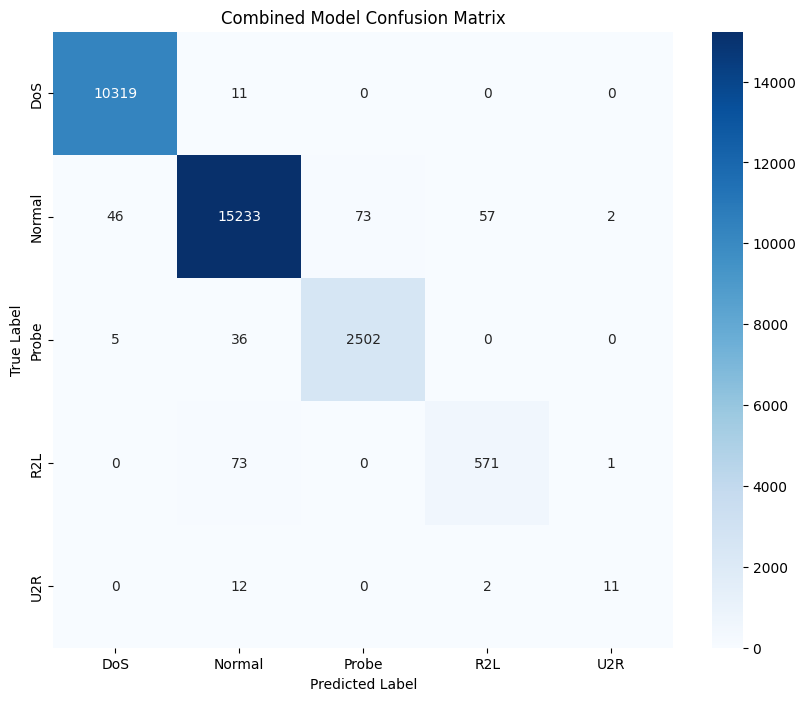

Models saved as 'anomaly_detector.pth' and 'attack_classifier.pth'.


In [ ]:

#we train the anomaly detector
print("Training Anomaly Detector on", device)

num_features_ad = X_train_ad.shape[1]
model_ad = TabularAnomalyDetector(num_features_ad).to(device)

criterion_ad = nn.CrossEntropyLoss()
optimizer_ad = torch.optim.Adam(model_ad.parameters(), lr=0.001)

num_epochs_ad = 10
for epoch in range(num_epochs_ad):
    model_ad.train()
    running_loss = 0.0
    for X_batch, y_batch in train_ad_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_ad.zero_grad()
        outputs = model_ad(X_batch)
        loss = criterion_ad(outputs, y_batch)
        loss.backward()
        optimizer_ad.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_ad_loader.dataset)
    print(f"Anomaly Detector Epoch {epoch+1}/{num_epochs_ad}, Loss: {epoch_loss:.4f}")

#we train the anomally classifier
print("\nTraining Attack Classifier on", device)

num_features_ac = X_train_ac.shape[1]
num_classes_ac = len(attack_encoder.classes_)
model_ac = AttackClassifier(num_features_ac, num_classes_ac).to(device)

criterion_ac = nn.CrossEntropyLoss()
optimizer_ac = torch.optim.Adam(model_ac.parameters(), lr=0.001)

num_epochs_ac = 10
for epoch in range(num_epochs_ac):
    model_ac.train()
    running_loss = 0.0
    for X_batch, y_batch in train_ac_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_ac.zero_grad()
        outputs = model_ac(X_batch)
        loss = criterion_ac(outputs, y_batch)
        loss.backward()
        optimizer_ac.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_ac_loader.dataset)
    print(f"Attack Classifier Epoch {epoch+1}/{num_epochs_ac}, Loss: {epoch_loss:.4f}")

#evaluation
def evaluate_combined(model_ad, model_ac, test_loader, device, attack_encoder, test_df):
    model_ad.eval()
    model_ac.eval()

    all_preds = []
    all_true = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs_ad = model_ad(X_batch)
            preds_ad = torch.argmax(outputs_ad, dim=1).cpu().numpy()

            batch_preds = []
            for i, pred in enumerate(preds_ad):
                if pred == 0:
                    batch_preds.append('Normal')
                else:
                    sample = X_batch[i].unsqueeze(0)
                    output_ac = model_ac(sample)
                    pred_ac = torch.argmax(output_ac, dim=1).cpu().numpy()
                    attack_class = attack_encoder.inverse_transform(pred_ac)[0]
                    batch_preds.append(attack_class)
            all_preds.extend(batch_preds)

    true_labels = np.where(test_df['is_anomaly'] == 1, test_df['attack_class'], 'Normal')

    print("\nCombined Model Classification Report:")
    print(classification_report(true_labels, all_preds))

    cm = confusion_matrix(true_labels, all_preds, labels=np.unique(true_labels))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Combined Model Confusion Matrix')
    plt.show()

evaluate_combined(model_ad, model_ac, test_ad_loader, device, attack_encoder, test_df)

#saving models
torch.save(model_ad.state_dict(), "anomaly_detector.pth")
torch.save(model_ac.state_dict(), "attack_classifier.pth")
print("Models saved as 'anomaly_detector.pth' and 'attack_classifier.pth'.")

# 1D Convolution Model

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Load and merge train/test .txt files
df_train = pd.read_csv("Train.txt", header=None)
df_test = pd.read_csv("Test.txt", header=None)
df = pd.concat([df_train, df_test], ignore_index=True)

# Assign column names manually (last column is 'attack')
df.columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "attack", "last_flag"
]

# Map detailed attacks to high-level categories
attack_mapping = {
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS',
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe',
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L',
    'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
    'normal': 'Normal'
}

# Apply mapping
df['attack_class'] = df['attack'].map(attack_mapping)
df = df[df['attack_class'].notnull()]  # Drop unknown attacks

# Create binary anomaly label
df['is_anomaly'] = df['attack_class'].apply(lambda x: 0 if x == 'Normal' else 1)

# Encode categorical columns
df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])

# Encode multi-class target
attack_encoder = LabelEncoder()
df['attack_class_encoded'] = attack_encoder.fit_transform(df['attack_class'])

# Prepare features and labels
features = df.drop(columns=['attack', 'attack_class', 'attack_class_encoded', 'is_anomaly', 'last_flag'])
X = StandardScaler().fit_transform(features.values)
y_anomaly = df['is_anomaly'].values
y_attack = df['attack_class_encoded'].values

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_anomaly_tensor = torch.tensor(y_anomaly, dtype=torch.float32)
y_attack_tensor = torch.tensor(y_attack, dtype=torch.long)

# Train/test split
X_train, X_test, y_anom_train, y_anom_test, y_att_train, y_att_test = train_test_split(
    X_tensor, y_anomaly_tensor, y_attack_tensor, test_size=0.2, stratify=y_attack_tensor, random_state=42
)

# Create data loaders
train_dataset = TensorDataset(X_train, y_anom_train, y_att_train)
test_dataset = TensorDataset(X_test, y_anom_test, y_att_test)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

C:\Users\cclab1\AppData\Local\Temp\ipykernel_14100\75205007.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='attack_class', data=df, palette='Set2')


<Axes: xlabel='attack_class', ylabel='count'>

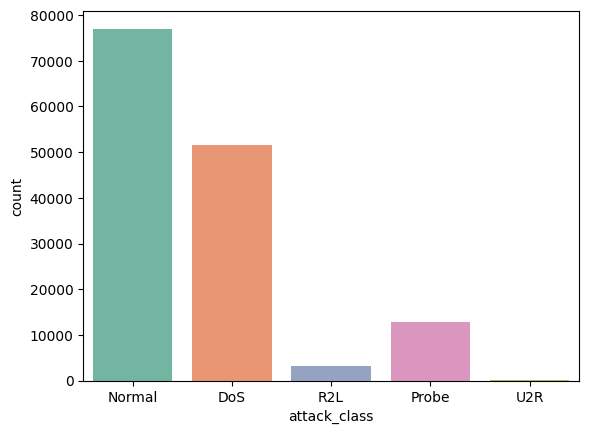

In [ ]:
import seaborn as sns
sns.countplot(x='attack_class', data=df, palette='Set2')

In [ ]:
df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_class_encoded
0,0,491,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,1
1,0,146,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,1
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,False,0
3,0,232,8153,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,True,False,1
4,0,199,420,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,True,False,1


In [ ]:
X_train.shape

torch.Size([115813, 122])

In [ ]:
y_anom_train.shape

torch.Size([115813])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define 1D CNN Model
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for 1D CNN
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.bn2(torch.relu(self.conv2(x)))
        x = self.bn3(torch.relu(self.conv3(x)))
        x = self.global_pool(x).squeeze(-1)  # Global average pooling
        x = self.dropout(x)
        return self.fc(x)

# Model Parameters
input_dim = X_train.shape[1]  # Number of features
num_classes = len(torch.unique(y_attack_tensor))  # Multi-class classification

# Initialize Model
model = CNN1D(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



CNN1D(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, _, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/20, Loss: 0.2407
Epoch 2/20, Loss: 0.0704
Epoch 3/20, Loss: 0.0554
Epoch 4/20, Loss: 0.0484
Epoch 5/20, Loss: 0.0434
Epoch 6/20, Loss: 0.0409
Epoch 7/20, Loss: 0.0390
Epoch 8/20, Loss: 0.0366
Epoch 9/20, Loss: 0.0347
Epoch 10/20, Loss: 0.0339
Epoch 11/20, Loss: 0.0320
Epoch 12/20, Loss: 0.0310
Epoch 13/20, Loss: 0.0304
Epoch 14/20, Loss: 0.0287
Epoch 15/20, Loss: 0.0283
Epoch 16/20, Loss: 0.0282
Epoch 17/20, Loss: 0.0262
Epoch 18/20, Loss: 0.0255
Epoch 19/20, Loss: 0.0263
Epoch 20/20, Loss: 0.0259


In [ ]:
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for X_batch, _, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

# Print Classification Report
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.9495
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     10334
           1       0.91      1.00      0.95     15411
           2       1.00      0.95      0.97      2552
           3       1.00      0.49      0.65       639
           4       0.50      0.06      0.10        18

    accuracy                           0.95     28954
   macro avg       0.88      0.68      0.73     28954
weighted avg       0.95      0.95      0.95     28954

Confusion Matrix:
 [[ 9355   978     1     0     0]
 [    1 15399    11     0     0]
 [    0   125  2427     0     0]
 [    0   328     0   310     1]
 [    0    17     0     0     1]]


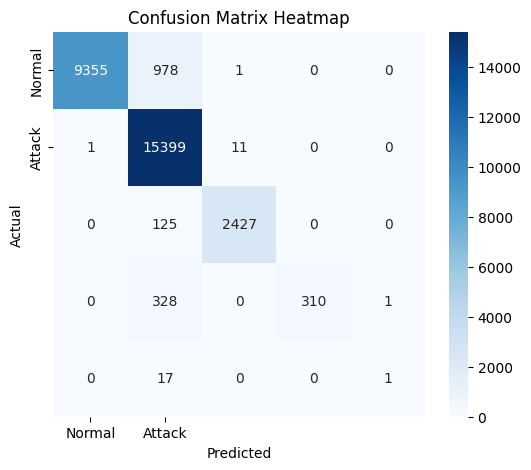

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()